In [56]:
!pip install ISLP

In [57]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from ISLP import confusion_table
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [58]:
#load in data
X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('y_train.txt', header=None).values.ravel()
X_test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('y_test.txt', header=None).values.ravel()

<ipython-input-58-770bfa779118>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None)
<ipython-input-58-770bfa779118>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(2570, 561)
(7352,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(1636, 561)
(2947,)


# Linear Discriminant Analysis (LDA)

In [59]:
#scale x
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(2570, 561)
(1636, 561)


In [60]:
#fit LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

y_pred = lda.predict(X_test_scaled)

In [61]:
#manual accuracy score calculation
correct_predictions = (y_test == y_pred).sum()
total_predictions = len(y_test)
accuracy_score = correct_predictions / total_predictions

print(f"Accuracy Score: {accuracy_score:.4f}")

Accuracy Score: 0.9623


In [ ]:
#identify misclassifications with confusion table
conf_table = confusion_table(y_test, y_pred)

print("Confusion Table:")
print(conf_table)

Confusion Table:
Truth        1    2    3    4    5    6
Predicted                              
1          490    6    0    0    0    0
2           11  460    0    0    0    0
3            1   14  405    0    0    0
4            0    1    0  434   56    0
5            0    0    0   22  510    0
6            0    0    0    0    0  537


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report for Best:
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       496
           2       0.96      0.98      0.97       471
           3       1.00      0.96      0.98       420
           4       0.95      0.88      0.92       491
           5       0.90      0.96      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



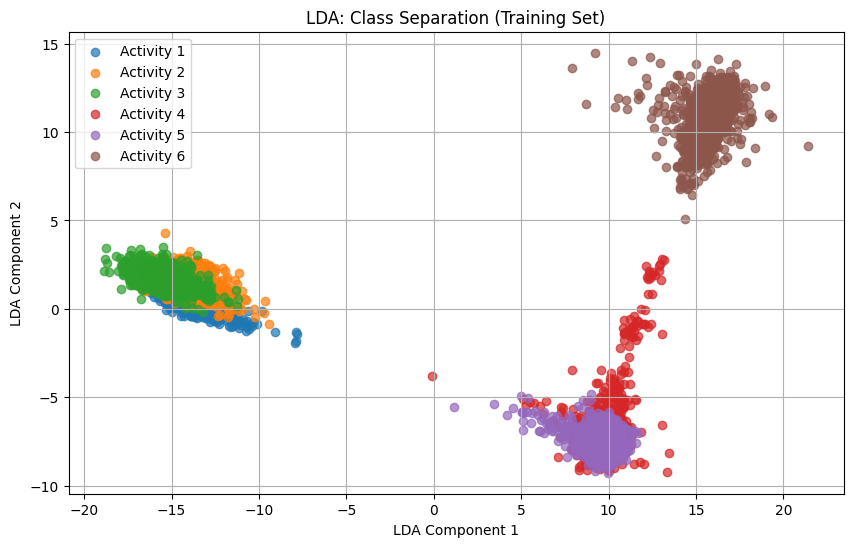

In [ ]:
#create plot to show class separation
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    plt.scatter(
        X_train_lda[y_train == label, 0],
        X_train_lda[y_train == label, 1],
        label=f"Activity {label}",
        alpha=0.7
    )
plt.title("LDA: Class Separation (Training Set)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
coefficients = pd.DataFrame(lda.coef_, columns=[f"Feature {i+1}" for i in range(X_train.shape[1])], index=lda.classes_)
print("\nTop Features by Class:")
for class_label in coefficients.index:
    print(f"\nClass {class_label}:")
    print(coefficients.loc[class_label].sort_values(ascending=False).head(5))


Top Features by Class:

Class 1:
Feature 99     904.308763
Feature 5      333.507746
Feature 4      288.763860
Feature 394    186.716645
Feature 390    166.169732
Name: 1, dtype: float64

Class 2:
Feature 99     1382.115165
Feature 4       416.478238
Feature 5       306.480959
Feature 6       272.155886
Feature 408     226.812133
Name: 2, dtype: float64

Class 3:
Feature 99     1679.161821
Feature 4       728.445767
Feature 5       567.716578
Feature 176     273.306801
Feature 394     237.449577
Name: 3, dtype: float64

Class 4:
Feature 98     940.861630
Feature 97     822.032458
Feature 233    279.661050
Feature 84     205.525481
Feature 86     171.766482
Name: 4, dtype: float64

Class 5:
Feature 98     897.708113
Feature 97     864.580360
Feature 233    218.120416
Feature 84     206.997440
Feature 269    173.759806
Name: 5, dtype: float64

Class 6:
Feature 97     740.493630
Feature 98     547.200110
Feature 270    199.683871
Feature 84     162.570254
Feature 86     156.109520
Name: 

The LDA model demonstrates excellent performance, achieving an overall accuracy of 96% and strong class-wise metrics. The model's accuracy score is 0.9623. The classification report highlights strong precision, recall, and F1-scores across all activity classes, with especially high performance for "LAYING" (F1-score = 1.00) and "WALKING" (F1-score = 0.98, recall = 0.99, precision = 0.98), as well as "WALKING DOWNSTAIRS" (F1-score = 0.98, precision = 1.00). However, "SITTING" showed slightly lower performance (F1-score = 0.92, recall = 0.88), indicating room for improvement in distinguishing this activity. Additionally, "STANDING" achieved an F1-score of 0.93, with slightly lower precision (0.90).

# Quadratic Discriminant Analysis (QDA)

We use the same scaled features as in LDA, with performance evaluated with adjusted R-squared and Mean Squared Error.



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


activity_labels = pd.read_csv("activity_labels.txt", header=None, delim_whitespace=True, index_col=0)
activity_labels = activity_labels[1].to_dict()
reg_params = np.linspace(0, 1, 21)

best_reg_param = None
best_accuracy = 0
best_model = None
best_mse = None
best_r2 = None
best_adj_r2 = None

n_samples, n_features = X_test_scaled.shape

print("Testing different values of reg_param:\n")

for reg_param in reg_params:
    qda = QuadraticDiscriminantAnalysis(reg_param=reg_param)
    qda.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = qda.predict(X_test_scaled)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_reg_param = reg_param
        best_model = qda
        best_mse = mse
        best_r2 = r2
        best_adj_r2 = adj_r2


print(f"\nBest reg_param:, {best_reg_param:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")
print(f"Best MSE: {best_mse:.4f}")
print(f"Best R²: {best_r2:.4f}")
print(f"Best Adjusted R²: {best_adj_r2:.4f}")


y_pred_best = best_model.predict(X_test_scaled)

print("\nClassification Report for Best:")
print(classification_report(y_test, y_pred_best, target_names=activity_labels.values()))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(conf_matrix)



<ipython-input-9-b35e970c7f26>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv("activity_labels.txt", header=None, delim_whitespace=True, index_col=0)


Testing different values of reg_param:



/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc


Best reg_param:, 0.65
Best Accuracy: 0.94
Best MSE: 0.0943
Best R²: 0.9688
Best Adjusted R²: 0.9615

Classification Report for Best:
                    precision    recall  f1-score   support

           WALKING       0.96      0.96      0.96       496
  WALKING_UPSTAIRS       0.91      0.97      0.94       471
WALKING_DOWNSTAIRS       0.95      0.87      0.91       420
           SITTING       0.96      0.82      0.88       491
          STANDING       0.86      0.97      0.91       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.94      0.93      2947


Confusion Matrix:
[[478   3  15   0   0   0]
 [  9 459   3   0   0   0]
 [ 11  42 367   0   0   0]
 [  0   1   0 401  87   2]
 [  0   0   0  18 514   0]
 [  0   0   0   0   0 537]]


The model's best accuracy was 94%, supported by a low mean squared error (MSE) of 0.0943, a high R² of 0.9688, and an adjusted R² of 0.9615. The classification report highlights strong precision, recall, and F1-scores across all activity classes, with especially high performance for "LAYING" (F1-score = 1.00) and "WALKING" (F1-score = 0.96). However, "SITTING" showed a slightly lower recall (0.82), indicating some misclassification with "STANDING." The confusion matrix confirms this trend, showing minor overlaps in predictions for similar activities.

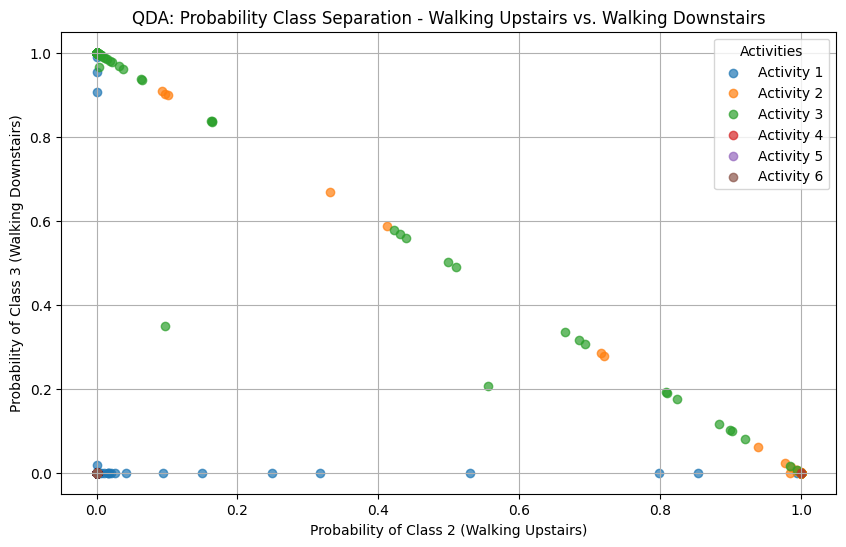

In [ ]:
qda_train_probs = best_model.predict_proba(X_train_scaled)
qda_test_probs = best_model.predict_proba(X_test_scaled)

# Select two dimensions for visualization
qda_train_dim1 = qda_train_probs[:, 1]  # Probabilities for the second class (Walking Upstairs)
qda_train_dim2 = qda_train_probs[:, 2]  # Probabilities for the third class (Walking Downstairs)

# Create the scatter plot
plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    mask = (y_train == label)
    plt.scatter(
        qda_train_dim1[mask],
        qda_train_dim2[mask],
        label=f"Activity {label}",
        alpha=0.7
    )

# Set plot title and labels
plt.title("QDA: Probability Class Separation - Walking Upstairs vs. Walking Downstairs")
plt.xlabel("Probability of Class 2 (Walking Upstairs)")
plt.ylabel("Probability of Class 3 (Walking Downstairs)")
plt.legend(loc="best", title="Activities")
plt.grid(True)
plt.show()

# K-Nearest Neighbors (KNN)

Running KNN with k = 5

In [62]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

X_train = np.loadtxt('X_train.txt')
y_train = np.loadtxt('y_train.txt')
X_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('y_test.txt')

unique_classes = np.unique(y_train)
class_names = [f"class {int(c)}" for c in unique_classes]

#create model with 5 splits
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    knn.fit(X_train_fold, y_train_fold)

    y_val_pred = knn.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(accuracy)

print("Cross-validation accuracies:", fold_accuracies)
print("Mean cross-validation accuracy:", np.mean(fold_accuracies))

knn.fit(X_train, y_train)

y_test_pred = knn.predict(X_test)

classification_report_table = classification_report(
    y_test, y_test_pred, target_names=class_names, output_dict=True
)

report_df = pd.DataFrame(classification_report_table).transpose()
print("Classification Metrics Report:")
print(report_df)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Cross-validation accuracies: [0.9639700883752549, 0.9592114208021754, 0.964625850340136, 0.9714285714285714, 0.9659863945578231]
Mean cross-validation accuracy: 0.9650444651007921
Classification Metrics Report:
              precision    recall  f1-score      support
class 1        0.850877  0.977823  0.909944   496.000000
class 2        0.894515  0.900212  0.897354   471.000000
class 3        0.953757  0.785714  0.861619   420.000000
class 4        0.908879  0.792261  0.846572   491.000000
class 5        0.831933  0.930451  0.878438   532.000000
class 6        1.000000  0.994413  0.997199   537.000000
accuracy       0.901595  0.901595  0.901595     0.901595
macro avg      0.906660  0.896812  0.898521  2947.000000
weighted avg   0.905930  0.901595  0.900698  2947.000000
Test set accuracy: 0.9015948422124194


Confusion Matrix

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train = np.loadtxt('X_train.txt')
y_train = np.loadtxt('y_train.txt')
X_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('y_test.txt')

unique_classes = np.unique(y_train)
class_names = [f"class {int(c)}" for c in unique_classes]

k = 5
knn = KNeighborsClassifier(n_neighbors=k)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    knn.fit(X_train_fold, y_train_fold)
    y_val_pred = knn.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(accuracy)

print("Cross-validation accuracies:", fold_accuracies)
print("Mean cross-validation accuracy:", np.mean(fold_accuracies))

knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)

classification_report_table = classification_report(
    y_test, y_test_pred, target_names=class_names, output_dict=True
)
report_df = pd.DataFrame(classification_report_table).transpose()
print("Classification Metrics Report:")
print(report_df)

conf_matrix = confusion_matrix(y_test, y_test_pred)

print(conf_matrix)

R2 Tests

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score

X_train = np.loadtxt('X_train.txt')
y_train = np.loadtxt('y_train.txt')
X_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('y_test.txt')

k = 5
knn = KNeighborsClassifier(n_neighbors=k)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_r2_scores = []
fold_adj_r2_scores = []

n_features = X_train.shape[1]

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    knn.fit(X_train_fold, y_train_fold)

    y_val_pred = knn.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(accuracy)

    r2 = r2_score(y_val_fold, y_val_pred)
    fold_r2_scores.append(r2)

    n = len(y_val_fold)  # Number of observations
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    fold_adj_r2_scores.append(adj_r2)

print("Cross-validation accuracies:", fold_accuracies)
print("Mean cross-validation accuracy:", np.mean(fold_accuracies))
print("Cross-validation R-squared:", fold_r2_scores)
print("Mean cross-validation R-squared:", np.mean(fold_r2_scores))
print("Mean cross-validation Adjusted R-squared:", np.mean(fold_adj_r2_scores))

knn.fit(X_train, y_train)

y_test_pred = knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
n_test = len(y_test)
adj_r2_test = 1 - ((1 - test_r2) * (n_test - 1) / (n_test - n_features - 1))

print("Test set accuracy:", test_accuracy)
print("Test set R-squared:", test_r2)
print("Test set Adjusted R-squared:", adj_r2_test)

# Support Vector Machine (SVM)

Running this code is going to take 3-5 hours I will take care of it Saturday afternoon when I get home. -- Nick



In [ ]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report

# import files for google: train and test data
from google.colab import files
uploaded = files.upload()
uploaded_2 = files.upload()

Saving test.csv to test (1).csv


Saving train.csv to train (1).csv


In [ ]:
train_svm = pd.read_csv('train.csv')
test_svm = pd.read_csv('test.csv')

# allocating predictor to x and classes in y
X_train_svm = train_svm.drop(columns=[train_svm.columns[-2], train_svm.columns[-1]])
y_train_svm = train_svm.iloc[:, -1]
X_test_svm = test_svm.drop(columns=[test_svm.columns[-2], test_svm.columns[-1]])
y_test_svm = test_svm.iloc[:, -1]

In [ ]:
# scales data to be standardized, mean of 0 and variance of 1 to maintain consistency between predictors
scaler = StandardScaler()
X_train_scaled_svm = scaler.fit_transform(X_train_svm)
X_test_scaled_svm = scaler.fit_transform(X_test_svm)

In [ ]:
# cross-validation
kfold = skm.KFold(5, random_state=0, shuffle=True)

# radial basis function
svm_rbf = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')
svm_rbf.fit(X_train_scaled_svm, y_train_svm)

grid_rbf = skm.GridSearchCV(svm_rbf, {'C':[0.001,0.01,0.1,1,5,10,100],
                                   'gamma':[0.001,0.01,0.1,1,5,10,100]},
                                    refit=True,
                                    cv=kfold,
                                    scoring='accuracy')

grid_rbf.fit(X_train_scaled_svm, y_train_svm)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='accuracy')

In [ ]:
# polynomial kernel function
svm_poly = SVC(kernel='poly', C=1.0, decision_function_shape='ovr')
svm_poly.fit(X_train_scaled_svm, y_train_svm)

grid_poly = skm.GridSearchCV(svm_poly, {'C':[0.001,0.01,0.1,1,5,10,100],
                                   'degree':[1,2,3,4,5]},
                                    refit=True,
                                    cv=kfold,
                                    scoring='accuracy')

grid_poly.fit(X_train_scaled_svm, y_train_svm)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(kernel='poly'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'degree': [1, 2, 3, 4, 5]},
             scoring='accuracy')

In [ ]:
print("Best parameter values for kernel=rbf:\n")
grid_rbf.best_params_

Best parameter values for kernel=rbf:



{'C': 100, 'gamma': 0.001}

In [ ]:
print("Best parameter values for kernel=poly\n")
grid_poly.best_params_

Best parameter values for kernel=poly



{'C': 100, 'degree': 2}

In [ ]:
# build svm with the ideal values for hyperparameters (kernel = 'rbf')
svm_rbf_best = SVC(kernel='rbf', C=100, gamma=0.001, decision_function_shape='ovr')
svm_rbf_best.fit(X_train_scaled_svm, y_train_svm)

y_pred_svm1 = svm_rbf_best.predict(X_test_scaled_svm)

print("Accuracy Score kernel=rbf:\n", (y_test_svm == y_pred_svm1).sum() / len(y_test_svm))
print("Confusion Table kernel=rbf:\n", confusion_table(y_test_svm, y_pred_svm1))

Accuracy Score kernel=rbf:
 0.9626739056667798
Confusion Table kernel=rbf:
 Truth               LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
Predicted                                                                    
LAYING                 537        0         0        0                   0   
SITTING                  4      449        37        0                   0   
STANDING                 0       19       513        0                   0   
WALKING                  0        0         0      477                  10   
WALKING_DOWNSTAIRS       0        0         0        4                 396   
WALKING_UPSTAIRS         0        0         0        4                   2   

Truth               WALKING_UPSTAIRS  
Predicted                             
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                            9  
WALKING_DOWNSTAIRS                20  
WALKING_UPSTAIRS          

In [ ]:
# build svm with the ideal values for hyperparameters (kernel = 'poly')
# TODO: determine ideal values for hyperparameters. They may or may not be C=100 and degree=1.
svm_poly_best = SVC(kernel='poly', C=100, degree=2, decision_function_shape='ovr')
svm_poly_best.fit(X_train_scaled_svm, y_train_svm)

y_pred_svm2 = svm_poly_best.predict(X_test_scaled_svm)

print("Accuracy Score kernel=poly:\n", (y_test_svm == y_pred_svm2).sum() / len(y_test_svm))
print("Confusion Table kernel=poly:\n", confusion_table(y_test_svm, y_pred_svm2))

Accuracy Score kernel=poly:
 0.9368849677638276
Confusion Table kernel=poly:
 Truth               LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
Predicted                                                                    
LAYING                 535        0         0        0                   2   
SITTING                  2      451        35        0                   0   
STANDING                 0       25       507        0                   0   
WALKING                  0       32         0      453                  11   
WALKING_DOWNSTAIRS       0       23         0        3                 369   
WALKING_UPSTAIRS         0       13         1       10                   1   

Truth               WALKING_UPSTAIRS  
Predicted                             
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                25  
WALKING_UPSTAIRS        

The best possible model, determined by our cross-validation, uses the radial basis function as its kernel function, with hyperparameter values C=100 and gamma=0.001, and has an accuracy score of 0.9626739056667798.

In [ ]:
# classification report for svm model comparison
report_svm1 = classification_report(y_test_svm, y_pred_svm1)
report_svm2 = classification_report(y_test_svm, y_pred_svm2)

print(f"kernel='rbf' Classification Report\n {report_svm1}\n")
print(f"kernel='poly' Classification Report\n {report_svm2}\n")

kernel='rbf' Classification Report
                     precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.91      0.94       491
          STANDING       0.93      0.96      0.95       532
           WALKING       0.98      0.96      0.97       496
WALKING_DOWNSTAIRS       0.97      0.94      0.96       420
  WALKING_UPSTAIRS       0.94      0.99      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947


kernel='poly' Classification Report
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.83      0.92      0.87       491
          STANDING       0.93      0.95      0.94       532
           WALKING       0.97      0.91      0.94       496
WALKING_DOWNSTAIRS    

The cross-validation grid search method returned results for the ideal values of the hyperparameters. The ideal regularization hyperparameter was 100, and the ideal kernel hyperparameters for the RBF and poly kernel functions respectively were 0.001 and 2. The radial basis function kernel returned a higher accuracy score of 96.27\%. The model also has its own corresponding confusion table, which displays the total number of classifications for each class as well as each unsuccessful classification, stratified by true class. A classification report is also made, which displays the precision, recall, and F1 score of each category within the model. All of these values are metrics which can be used to compare the effectiveness between statistical models.